# Captum

In [1]:
from functools import lru_cache
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xarray as xr
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
import pytorch_lightning as pl
from captum.attr import IntegratedGradients, Saliency, DeepLift, GuidedGradCam, NoiseTunnel, LayerGradCam
from captum.attr import visualization as viz

from arnet.modeling.learner import Learner
from arnet.dataset import ActiveRegionDataModule, ActiveRegionDataset
from arnet.transforms import get_transform
from mlflow_helper import retrieve
from captum_helper import get_heatmap, plot_heatmaps_info, add_label, add_pred
from cotrain_helper import get_learner_by_query
retrieve = lru_cache(retrieve)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/zeyusun/work/flare-prediction-smarp/arnet/constants.py:22: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  CONSTANTS = get_constants()


In [2]:
df = pd.read_csv('_selected.csv', index_col=0).reset_index(drop=True)
# from arnet/fusion.py
df.loc[:, 'flares'] = df['flares'].fillna('')
df.loc[:, 'bad_img_idx'] = df['bad_img_idx'].apply(
    lambda s: [int(x) for x in s.strip('[]').split()])

In [3]:
algorithms = ['Original', 'Saliency', 'IntegratedGradients', 'DeepLift', 'GuidedGradCam', 'LayerGradCam'] #, 'LayerLRP']
zmax = None #[10, 0.05, 0.05, 0.05, 0.0005, 0.1] # adaptive
zmin = None #[-z for z in zmax]
color_continuous_scale = [
    px.colors.sequential.gray,
    *([px.colors.diverging.RdBu_r] * 5), #balance # white for 0.
]

## Single frame

In [4]:
heatmaps = {a: [None] * len(df) for a in algorithms}
for model_query, subdf in df.groupby('model_query'):
    learner = get_learner_by_query(model_query).to('cuda')
    cfg = learner.cfg
    transform = Compose([get_transform(name, cfg)
                         for name in cfg.DATA.TRANSFORMS] +
                        [lambda video: video.to('cuda')])
    dataset = ActiveRegionDataset(
        subdf,
        features=['MAGNETOGRAM'],
        num_frames=1,
        transform=transform
    )
    dataloader = DataLoader(
        dataset,
        batch_size=16,
        #shuffle=False,
        #num_workers=8,
        #pin_memory=False,
        #drop_last=False,
    )

    for algorithm in tqdm(algorithms):
        hs = []
        for videos, sizes, labels, meta in dataloader:
            h = get_heatmap(algorithm, learner, videos, labels).cpu().detach().numpy()
            hs.append(h)
        hmaps = np.concatenate(hs) # along the batch dimension
        
        for i, m in zip(subdf.index, hmaps):
            heatmaps[algorithm][i] = m

dict_values(['cv', 'cv', 'sharp', '0', '0', 'CNN'])
Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
241 2021-09-09 17:32:31.575000+00:00                  cv


  0%|          | 0/6 [00:00<?, ?it/s]

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Approximation delta:  tensor([0.0190], device='cuda:0', dtype=torch.float64)


/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:60: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [108]:
## Inspect to tune hyperparameters
# heatmaps['IntegratedGradients'][0].shape
# plt.hist(heatmaps['IntegratedGradients'][0].ravel())
# plt.hist(heatmaps['LayerGradCam'][1].ravel())

## Test for px.imshow to make sure the original functionality works
# px.imshow(heatmaps['LayerGradCam'][0].squeeze(), color_continuous_scale=px.colors.diverging.RdBu_r)

In [5]:
heatmaps['IntegratedGradients'][0].sum()

5.667694624800448

prefix  arpnum              t_start                t_end  label     flares  \
0   HARP    1621  2012-05-06 00:00:00  2012-05-07 00:00:00   True  C1.1|M1.9   

  bad_img_idx  HEIGHT  WIDTH          SUM  ...       USFLUXL  MEANGBL  \
0          []     117    271  63272.15625  ...  1.893659e+22   22.292   

    R_VALUE     prob0     prob1     prob2     prob3     prob4      mean  \
0  3.035041  0.816333  0.023087  0.264833  0.011575  0.002839  0.223734   

           model_query  
0  cv/cv/sharp/0/0/CNN  

[1 rows x 23 columns]

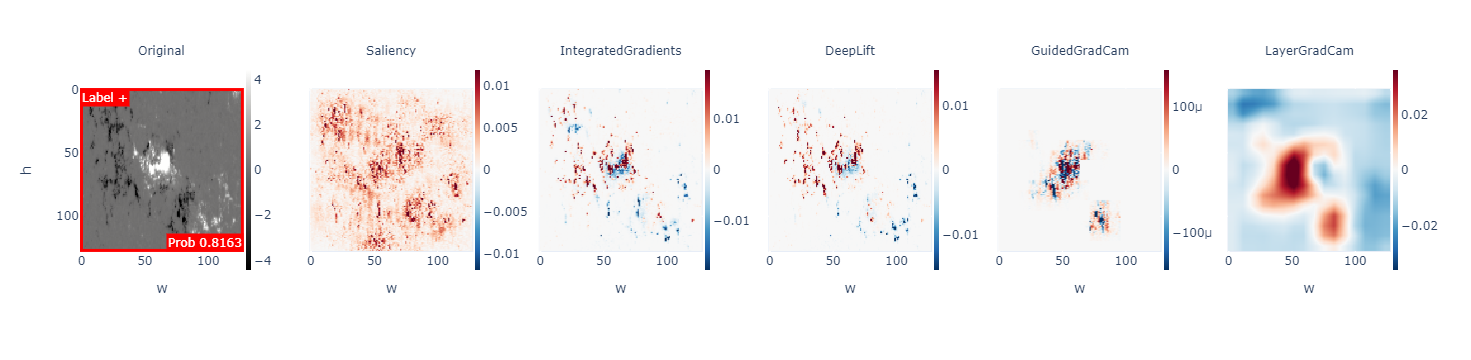

In [6]:
# m.shape = (C, T, H, W) is a single instance
g = lambda m: m[0, 0, :, :] #.transpose(1,2,0)
for i in df.index:
    display(df.iloc[[i]])

    imgs = np.array([g(heatmaps[a][i]) for a in heatmaps])
    algorithms = list(heatmaps.keys())
    fig = plot_heatmaps_info(imgs, algorithms, df.iloc[i],
                             zmin, zmax, color_continuous_scale,
                             animation_frame=None)
    fig.show(config={'modeBarButtonsToAdd':['drawopenpath', 'eraseshape']})

## Movie

In [23]:
heatmaps = {a: [None] * len(df) for a in algorithms}
for model_query, subdf in df.groupby('model_query'):
    learner = get_learner_by_query(model_query).to('cuda')
    cfg = learner.cfg
    transform = Compose([get_transform(name, cfg)
                         for name in cfg.DATA.TRANSFORMS] +
                        [lambda video: video.to('cuda')])
    dataset = ActiveRegionDataset(
        subdf,
        features=['MAGNETOGRAM'],
        num_frames=16,
        num_frames_after=15,
        transform=transform
    )
    dataloader = DataLoader(
        dataset,
        batch_size=16,
        #shuffle=False,
        #num_workers=8,
        #pin_memory=False,
        #drop_last=False,
    )

    for algorithm in tqdm(algorithms):
        hs = []
        for videos, sizes, labels, meta in dataloader:
            h = [get_heatmap(algorithm, learner, videos[:, :, [t]], labels).cpu().detach().numpy()
                 for t in range(videos.shape[2])]
            h = np.concatenate(h, axis=2)
            hs.append(h)
        hmaps = np.concatenate(hs) # along the batch dimension
        
        for i, m in zip(subdf.index, hmaps):
            heatmaps[algorithm][i] = m

dict_values(['cv', 'cv', 'sharp', '0', '0', 'CNN'])


  0%|          | 0/6 [00:00<?, ?it/s]

Approximation delta:  tensor([0.0025], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0676], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0389], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0113], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0482], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0089], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0054], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0049], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0104], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0536], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0306], device='cuda:0', dtype=torch.float64)
Approximation delta:  tensor([0.0430], device='cuda:0', dtype=torch.float64)

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:60: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [ ]:
# m.shape = (C, T, H, W) is a single instance
f = lambda m: m[0, :, :, :] #.transpose(1,2,0)
for i in df.index:
    display(df.iloc[[i]])

    imgs = np.array([f(heatmaps[a][i]) for a in heatmaps])
    algorithms = list(heatmaps.keys())
    fig = plot_heatmaps_info(imgs, algorithms, df.iloc[i],
                             zmin, zmax, color_continuous_scale,
                             animation_frame=1)
    fig.show(config={'modeBarButtonsToAdd':['drawopenpath', 'eraseshape']})

## Single instance

In [220]:
learner = get_learner_by_query('cv/cv/sharp/0/3/CNN')
cfg = learner.cfg
transform = Compose([get_transform(name, cfg)
                     for name in cfg.DATA.TRANSFORMS])
dataset = ActiveRegionDataset(
    subdf,
    features=['MAGNETOGRAM'],
    num_frames=1,
    transform=transform
)

dict_values(['cv', 'cv', 'sharp', '0', '3', 'CNN'])


In [82]:
learner.model.eval()
learner(dataset[0][0].unsqueeze(0) * 0)

tensor([[ 3.7575, -3.6881]], grad_fn=<AddmmBackward>)

## Prepare

In [57]:
experiment_name = 'leaderboard3'
run_name = 'val_tss'
runs = retrieve(experiment_name, run_name)

Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
245 2021-08-23 09:22:37.321000+00:00             val_tss


In [58]:
dataset_name = 'sharp'
estimator_name = 'CNN'
seed = 0

selected = runs.loc[
    (runs['tags.dataset_name'] == dataset_name) &
    (runs['params.DATA.SEED'] == str(seed)) &
    (runs['tags.estimator_name'] == estimator_name)
]
if len(selected) > 1:
    print('WARNING: more than 1 runs')

In [59]:
ckpt_path = selected['tags.checkpoint'].iloc[0]
learner = Learner.load_from_checkpoint(ckpt_path)
model = learner.model
model.eval()

kwargs = learner.cfg.TRAINER.todict()
# Saved under notebooks/mlruns and notebooks/lightning_logs
trainer = pl.Trainer(**kwargs)

dm = ActiveRegionDataModule(learner.cfg)
dl = dm.val_dataloader()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


AttributeError: VAL_SPLIT

## Visualization

In [55]:
%matplotlib inline

In [56]:
#videos, sizes, labels, meta = next(iter(dl[0]))
video, size, target, meta = dl[0].dataset[12]
print(target)

input = video.unsqueeze(0)

original_image = video.squeeze().cpu().detach().numpy()
original_image = np.stack([original_image] * 3, axis=2) # 128x128x3
norm = Normalize(vmin=-20, vmax=20, clip=True)
original_image = norm(original_image)

NameError: name 'dl' is not defined

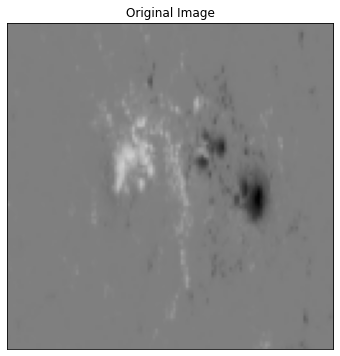

In [23]:
_ = viz.visualize_image_attr(
    None,
    original_image,
    method="original_image",
    title="Original Image"
)

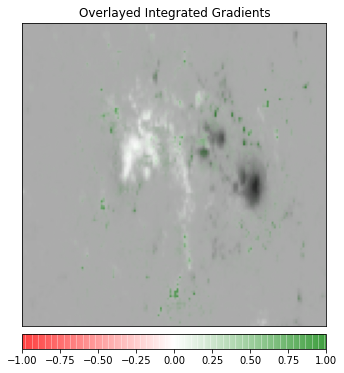

In [27]:
heatmap = get_heatmap(Saliency, learner, input, target)
_ = viz.visualize_image_attr(
    heatmap.squeeze().transpose((1,2,0)),
    original_image,
    method="blended_heat_map",
    sign="all",
    alpha_overlay=0.5,
    show_colorbar=True, 
    title="Overlayed Integrated Gradients"
)

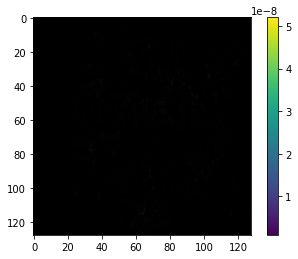

In [36]:
plt.imshow(heatmap.squeeze().transpose((1,2,0)))
plt.colorbar()

Approximation delta:  tensor([0.0036], dtype=torch.float64)


TypeError: Invalid shape (1, 1, 128, 128) for image data

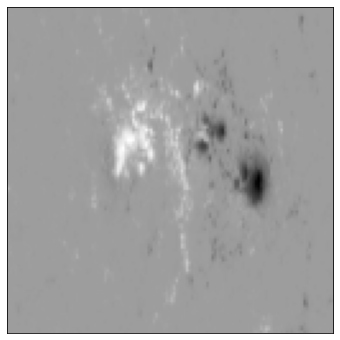

In [24]:
heatmap = get_heatmap(IntegratedGradients, learner, input, target)
_ = viz.visualize_image_attr(
    heatmap,
    original_image,
    method="blended_heat_map",
    sign="all",
    alpha_overlay=1,
    show_colorbar=True,
    title="Overlayed Integrated Gradients"
)

In [ ]:
#### Dangerous: used all memory
# heatmap = get_heatmap(NoiseTunnel, learner, input, target)
# _ = viz.visualize_image_attr(
#     heatmap,
#     original_image,
#     method="blended_heat_map",
#     sign="absolute_value",
#     outlier_perc=10,
#     #alpha_overlay=0.5,
#     show_colorbar=True,
#     title="Overlayed Integrated Gradients \n with SmoothGrad Squared"
# )

/home/zeyusun/work/captum/captum/attr/_core/deep_lift.py:321: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


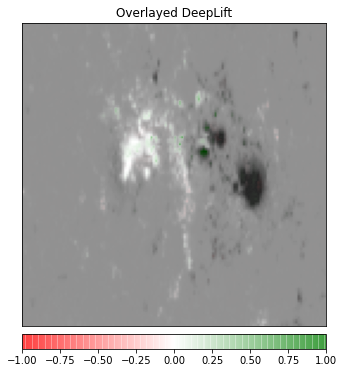

In [13]:
heatmap = get_heatmap(DeepLift, learner, input, target)
_ = viz.visualize_image_attr(
    heatmap,
    original_image,
    method="blended_heat_map",
    sign="all",
    #alpha_overlay=0.5,
    show_colorbar=True,
    title="Overlayed DeepLift"
)

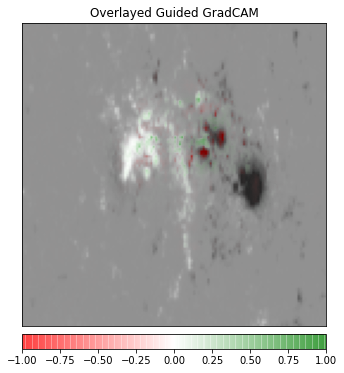

In [16]:
heatmap = get_heatmap(GuidedGradCam, learner, input, target)
_ = viz.visualize_image_attr(
    heatmap,
    original_image,
    method="blended_heat_map",
    sign="all",
    #alpha_overlay=0.5,
    show_colorbar=True,
    title="Overlayed Guided GradCAM"
)